<H1>Predicting Authors</H1>
<H2>Thinkful Supervised Learning Capstone Project</H2>
<H3>Michael Klear</H3>

In [176]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import log_loss, make_scorer
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import scipy
from collections import Counter
from time import time
from math import e

sns.set_style('darkgrid')

<H1>Model 1: Superficial Analysis</H1>

In [116]:
data = pd.read_csv('train.csv')

In [117]:
def prepare_data(data):
    """Calls data prep functions and returns appended df,
    list of features used in first model.
    """
    res = data
    res = tokenize_text(res)
    res, fts = build_features(res)
    res = lemmatize_text(res)
    return res, fts

def tokenize_text(data):
    """Takes a dataframe (after returning from build_features) and creates
    text features. appends new features to df and returns everything.
    """
    res = data
    res['tokens'] = data.text.apply(word_tokenize)
    res['tag_list'] = data.tokens.apply(lambda x: pos_tag(x))
    res['pos_list'] = data.tag_list.apply(lambda x: [tup[1] for tup in x])
    res['pos_sentence']= res['pos_list'].apply(lambda x: ' '.join(x))
    return res

def build_features(data):
    """Takes a dataframe with columns "tokens" and "text" and returns
    the same dataframe with "hand-built" features appended.
    """
    orig_len = len(data.columns)
    res = data.copy()
    res['sentence_length_chars'] = res.text.apply(len)
    res['text_stripped'] = res.text.str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))
    res['words'] = res.text_stripped.str.split()
    res['sentence_length_words'] = res.words.apply(len)
    res['mean_word_length'] = res.sentence_length_chars/res.sentence_length_words
    res['clauses'] = res.text.apply(lambda x: re.split("[;,:]", x))
    res['mean_clause_length'] = res.clauses.apply(lambda x: pd.Series(x).apply(len).mean())
    res['num_clauses'] = res.clauses.apply(len)
    res['contraction'] = (res.tokens.apply(len)-1) - res.sentence_length_words
    fts_list = list(res.columns[orig_len:])
    fts_list.remove('text_stripped')
    fts_list.remove('clauses')
    fts_list.remove('words')
    return res, fts_list

lem = WordNetLemmatizer()

def cust_lem(tag_list, lem):
    """Takes a tag list and lems appropriately. Returns a list of lemmed tokens."""
    result = []
    for tup in tag_list:
        if tup[1] == 'NNS' or tup[1] == 'NNPS':
            result.append(lem.lemmatize(tup[0], 'n'))
        elif tup[1][0:2] == 'VB':
            result.append(lem.lemmatize(tup[0], 'v'))
        else:
            result.append(tup[0])
    return result

def lemmatize_text(data):
    """Lemmatizes data using pos list to make appropriate call to lemmatizer."""
    res = data
    res['lemmed_words'] = res.tag_list.apply(lambda x: cust_lem(x, lem))
    res['recombined'] = res.lemmed_words.apply(lambda x: ' '.join(x))
    return res

In [118]:
data, fts = prepare_data(data)

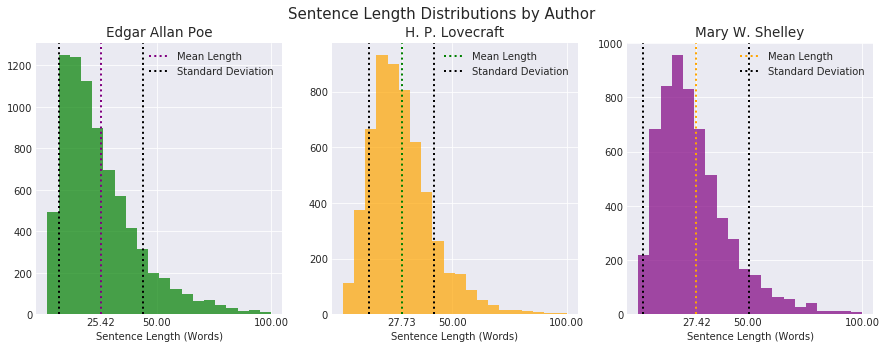

In [119]:
auth_colors = {}
auth_colors['EAP'] = 'g'
auth_colors['HPL'] = 'orange'
auth_colors['MWS'] = 'purple'

comp_colors = {}
comp_colors['EAP'] = 'purple'
comp_colors['HPL'] = 'g'
comp_colors['MWS'] = 'orange'

auth_names = {}
auth_names['EAP'] = 'Edgar Allan Poe'
auth_names['HPL'] = 'H. P. Lovecraft'
auth_names['MWS'] = 'Mary W. Shelley'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Sentence Length Distributions by Author', fontsize=15)

for i, auth in enumerate(data.author.unique()):
    ax[i].hist(
        data[(data.author==auth) & (data.sentence_length_words <= 100)].sentence_length_words, 
        bins=20,
        color=auth_colors[auth],
        alpha=.7,
        label=None
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean(), 
        linestyle='dotted',
        linewidth=2,
        color=comp_colors[auth],
        label='Mean Length',
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean() + data[data.author==auth].sentence_length_words.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label='Standard Deviation',
    );
    ax[i].axvline(
        x=data[data.author==auth].sentence_length_words.mean() - data[data.author==auth].sentence_length_words.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label=None
    );
    ax[i].set_title(auth_names[auth], fontsize=13.5);
    ax[i].set_xlabel('Sentence Length (Words)');
    xtkx = ax[i].get_xticks();
    xtkx = list(xtkx);
    xtkx = list([data[data.author==auth].sentence_length_words.mean()]) + [50, xtkx[6]]
    ax[i].set_xticks(xtkx);
    ax[i].legend();
#plt.tight_layout();
plt.show();

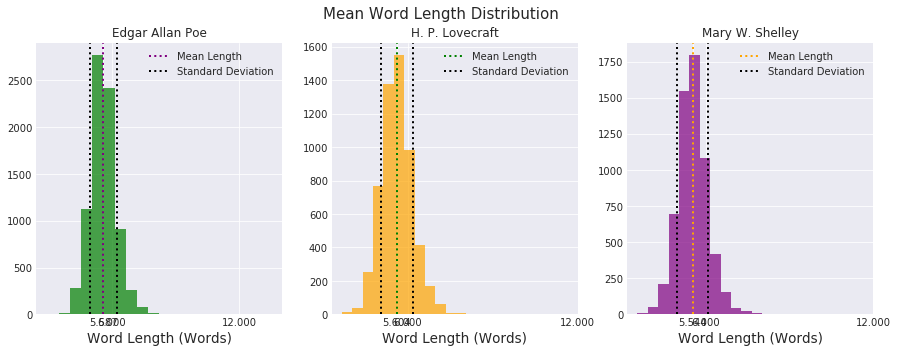

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Mean Word Length Distribution', fontsize=15)

for i, auth in enumerate(data.author.unique()):
    ax[i].hist(
        data[(data.author==auth) & (data.mean_word_length <= 100)].mean_word_length, 
        bins=20,
        color=auth_colors[auth],
        alpha=.7,
        label=None
    );
    ax[i].axvline(
        x=data[data.author==auth].mean_word_length.mean(), 
        linestyle='dotted',
        linewidth=2,
        color=comp_colors[auth],
        label='Mean Length',
    );
    ax[i].axvline(
        x=data[data.author==auth].mean_word_length.mean() + data[data.author==auth].mean_word_length.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label='Standard Deviation',
    );
    ax[i].axvline(
        x=data[data.author==auth].mean_word_length.mean() - data[data.author==auth].mean_word_length.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label=None
    );
    ax[i].set_title(auth_names[auth])
    ax[i].set_xlabel('Word Length (Words)', fontsize=13.5)
    xtkx = ax[i].get_xticks()
    xtkx = list(xtkx)
    xtkx = list([data[data.author==auth].mean_word_length.mean()]) + [6, xtkx[5]]
    ax[i].set_xticks(xtkx);
    ax[i].legend();
#plt.tight_layout();
plt.show();

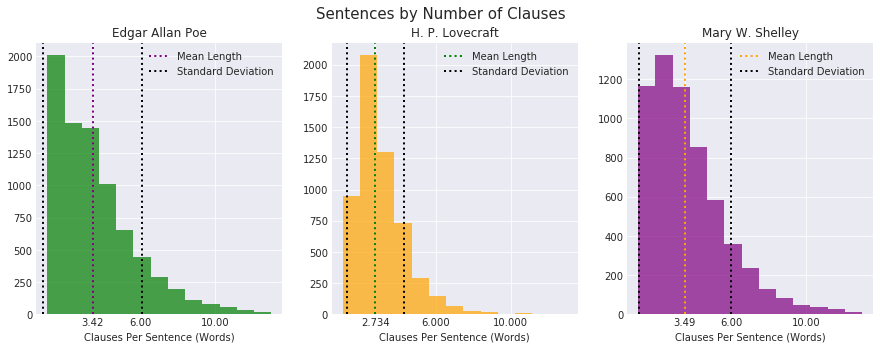

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Sentences by Number of Clauses', fontsize=15)

for i, auth in enumerate(data.author.unique()):
    ax[i].hist(
        data[(data.author==auth) & (data.num_clauses <= 13)].num_clauses, 
        bins=13,
        color=auth_colors[auth],
        alpha=.7,
        label=None
    );
    ax[i].axvline(
        x=data[data.author==auth].num_clauses.mean(), 
        linestyle='dotted',
        linewidth=2,
        color=comp_colors[auth],
        label='Mean Length',
    );
    ax[i].axvline(
        x=data[data.author==auth].num_clauses.mean() + data[data.author==auth].num_clauses.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label='Standard Deviation',
    );
    ax[i].axvline(
        x=data[data.author==auth].num_clauses.mean() - data[data.author==auth].num_clauses.std(), 
        linestyle='dotted',
        linewidth=2,
        color='black',
        label=None
    );
    ax[i].set_title(auth_names[auth])
    ax[i].set_xlabel('Clauses Per Sentence (Words)')
    xtkx = ax[i].get_xticks()
    xtkx = list(xtkx)
    xtkx = list([data[data.author==auth].num_clauses.mean()]) + [6, xtkx[5]]
    ax[i].set_xticks(xtkx);
    ax[i].legend();
#plt.tight_layout();
plt.show();

<H1>Model Evaluation Method</H1><br>
The competition is evaluated by log-loss. I use cross_evaluation with five stratified holdout groups and train/test my models on an 80%/20% training sample to test sample split. I compute the mean and standard deviation of the log loss between the five groups to minimize this evaluation metric.

In [123]:
fld = StratifiedKFold(n_splits=5, random_state=123)
df = data.copy()
    
results = pd.concat([res1, res2, res3], axis=1)
results.head()

def apply_model_1(mod, df, itrain, itest, fts):
    """takes dataframe, train indices, test indices, and list
    of feature names used in first model. Returns a dataframe
    with probabilities for each author for the test set.
    """
    mod = BernoulliNB()
    mod.fit(df[fts].loc[itrain], df.author.loc[itrain])
    cls = mod.classes_
    probs = mod.predict_proba(df[fts].loc[itest])
    res = pd.DataFrame(data=probs, index=itest, columns=['{}_prob1'.format(clas) for clas in cls])
    return res

In [130]:
X1 = data[fts]
Y = data.author
logl_score = make_scorer(log_loss, needs_proba=True)
nb1 = BernoulliNB()
t1 = time()
print('Testing NB Model...')
nb1_scores = pd.Series(cross_val_score(nb1, X1, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', nb1_scores.mean(), ' +/- ', nb1_scores.std())
nb1_acc_scores = pd.Series(cross_val_score(nb1, X1, Y, cv=5))
print('5-fold mean accuracy: ', nb1_acc_scores.mean(), ' +/- ', nb1_acc_scores.std())
nb1_time = time() - t1
print('Cross validation completed in: ', nb1_time, ' seconds')

Testing NB Model...
5-fold mean log loss:  1.08385261759  +/-  0.00180627224311
5-fold mean accuracy:  0.403493543207  +/-  4.6089037142e-05
Cross validation completed in:  0.9085419178009033  seconds


In [132]:
logl_score = make_scorer(log_loss, needs_proba=True)
rf1 = RandomForestClassifier()
t1 = time()
print('Testing RF Model...')
rf1_scores = pd.Series(cross_val_score(rf1, X1, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', rf1_scores.mean(), ' +/- ', rf1_scores.std())
rf1_time = time() - t1
print('Cross validation completed in: ', rf1_time, ' seconds')
rf1_acc_scores = pd.Series(cross_val_score(rf1, X1, Y, cv=5))
rf1_time = time() - t1
print('5-fold mean accuracy: ', rf1_acc_scores.mean(), ' +/- ', rf1_acc_scores.std())
print('Cross validation completed in: ', rf1_time, ' seconds')

Testing RF Model...
5-fold mean log loss:  4.86445592214  +/-  0.204899140915
Cross validation completed in:  1.4127018451690674  seconds
5-fold mean accuracy:  0.419990372536  +/-  0.00480068650296
Cross validation completed in:  2.7346749305725098  seconds


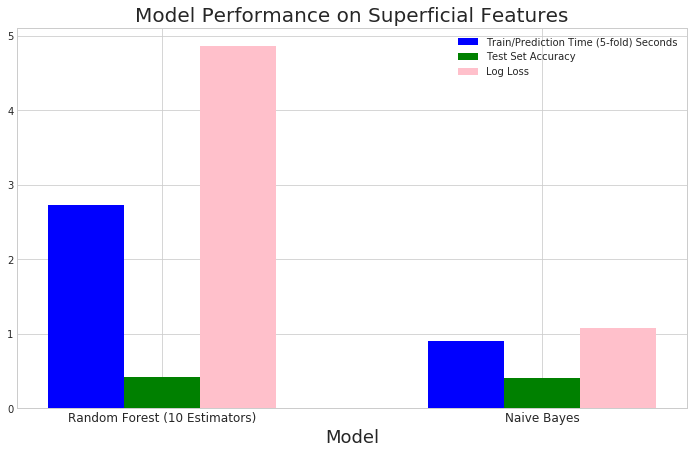

In [134]:
bar_width = .2
x = np.arange(2)
times = [rf1_time, nb1_time]
accs = [rf1_acc_scores.mean(), nb1_acc_scores.mean()]
losses = [rf1_scores.mean(), nb1_scores.mean()]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance on Superficial Features', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) Seconds');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=18);
plt.xticks(x, ['Random Forest (10 Estimators)', 'Naive Bayes'], fontsize=12);
plt.show();

<H1>Model 2: Significant N-Grams</H1>

In [135]:
def get_freq_vecs(data, min_freq=3):
    """Takes the dataframe and an optional minimum n-gram frequency and vectorizes the grams
    with CountVectorizer. Calculates a vector with global word frequencies (gram-wise sum
    of gram-count matrix), and an author-specific gram-wise sum. Returns a vector with the
    max and min gram-wise author-specific frequency as a fraction of the total global gram
    frequency.
    Returns a dataframe with the vectorizer vocabulary, a vector with max author-specific freqs,
    a vector with min author-specific freqs, and a vector of global word frequencies.
    """
    eap, hpl, mws = (
        data[data.author=='EAP'].recombined, 
        data[data.author=='HPL'].recombined, 
        data[data.author=='MWS'].recombined
    )

    vec = CountVectorizer(ngram_range=(1, 5), min_df=min_freq, stop_words='english')
    corpus = vec.fit_transform(data.recombined)
    vocab = vec.vocabulary_

    eap, hpl, mws = vec.transform(eap), vec.transform(hpl), vec.transform(mws)

    total_freq = corpus.todense().sum(axis=0)
    eap_freq = eap.todense().sum(axis=0)/total_freq
    hpl_freq = hpl.todense().sum(axis=0)/total_freq
    mws_freq = mws.todense().sum(axis=0)/total_freq

    freqs_max = np.array([eap_freq, hpl_freq, mws_freq]).max(axis=0)
    freqs_min = np.array([eap_freq, hpl_freq, mws_freq]).min(axis=0)

    vocab_frame = pd.DataFrame()
    vocab_frame['items'] = vocab.items()
    vocab_frame['gram'] = vocab_frame['items'].apply(lambda x: x[0])
    vocab_frame.index = vocab_frame['items'].apply(lambda x: x[1])
    return vocab_frame, freqs_max, freqs_min, total_freq
    
def get_best_grams(vocab_frame, freqs_max, freqs_min, freqs_tot, min_df=5, cutoff_min=.25, cutoff_max=.75):
    """Takes output from get_freq_vecs and filters based ona set of criteria:
    
    min_df is the minumum global frequency of a gram to pass the filter.
    grams with minimum author-specific frequencies below cutoff_min are admitted.
    grams with maximum author-specific frequencies above cutoff_max are admitted.
    
    Returns a list of admitted grams.
    """
    top_tier = np.where(freqs_max >= cutoff_max, 1, 0)
    bottom_tier = np.where(freqs_min <= cutoff_min, 1, 0)
    tot = np.where((top_tier + bottom_tier) > 0, True, False)
    tot = np.where(tot & (freqs_tot >= min_df), 1, 0)
    indcs = []
    if len(tot.shape) > 1:
        for i, val in enumerate(tot[0]):
            if val > 0:
                indcs.append(i)
    else:
        for i, val in enumerate(tot):
            if val > 0:
                indcs.append(i) 
    return list(vocab_frame.loc[indcs].gram)

def dynamic_cutoffs(global_freqs, expected_stds, voc, fmax, fmin, ftot, 
                    expected_mean=(1/3), std_scl=2, stop_freq=None, step_=1):
    """Takes a series of global frequencies and a series of "expected" standard devations
    and makes calls on get_best_grams to dynamically adjust cutoff. Collects best grams from
    each search, consolodates and returns them as a list.
    """
    if stop_freq == None:
        stop_ = int(ftot.max())
    else:
        stop_ = stop_freq
    result = []
    it = 0
    for i in range(ftot.min()-1, stop_, step_):
        it += 1
        if it%100==0:
            print('{} out of {} tasks completed.'.format(it, stop_))
        cutoff_flr = expected_mean - (std_scl*expected_stds.loc[i]*(2/3))
        cutoff_cl = expected_mean + (std_scl*expected_stds.loc[i]*(4/3))
        rs = get_best_grams(voc, fmax, fmin, ftot, min_df=global_freqs.loc[i], cutoff_min=cutoff_flr, cutoff_max=cutoff_cl)
        result += rs
    return list(set(result))

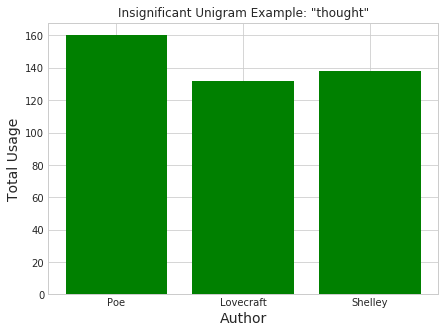

In [136]:
vals = {}
vals['EAP'] = 0
vals['HPL'] = 0
vals['MWS'] = 0
for i in data.index:
    row = data.loc[i]
    auth = row.author
    if 'thought' in row.words:
        vals[auth] += 1
nums = [vals['EAP'], vals['HPL'], vals['MWS']]
plt.figure(figsize=(7, 5))
plt.title('Insignificant Unigram Example: "thought"')
plt.bar([1, 2, 3], nums, color='green');
plt.ylabel('Total Usage', fontsize=14);
plt.xticks([1, 2, 3], ['Poe', 'Lovecraft', 'Shelley']);
plt.xlabel('Author', fontsize=14);
plt.show();

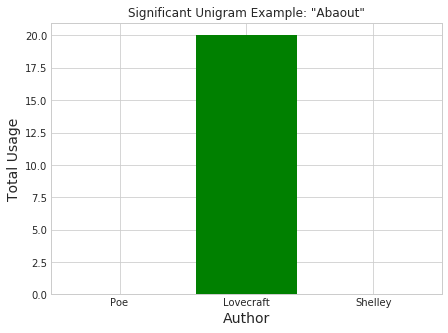

In [137]:
vals = {}
vals['EAP'] = 0
vals['HPL'] = 0
vals['MWS'] = 0
for i in data.index:
    row = data.loc[i]
    auth = row.author
    if 'abaout' in row.words:
        vals[auth] += 1
nums = [vals['EAP'], vals['HPL'], vals['MWS']]
plt.figure(figsize=(7, 5))
plt.title('Significant Unigram Example: "Abaout"')
plt.bar([1, 2, 3], nums, color='green');
plt.ylabel('Total Usage', fontsize=14);
plt.xticks([1, 2, 3], ['Poe', 'Lovecraft', 'Shelley']);
plt.xlabel('Author', fontsize=14);
plt.show();

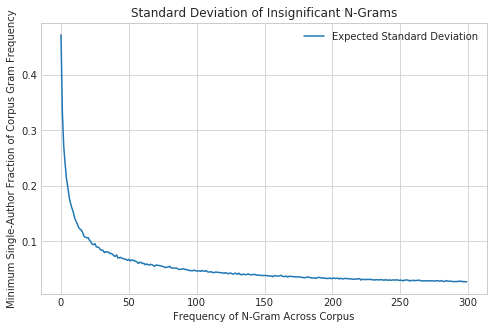

In [138]:
exp_devs = pd.read_csv('exp_std_chart.csv')

lk = exp_devs.iloc[:300]
plt.figure(figsize=(8, 5))
plt.title('Standard Deviation of Insignificant N-Grams')
plt.plot(lk.expected_standard_deviation, label='Expected Standard Deviation');
plt.xlabel('Frequency of N-Gram Across Corpus');
plt.ylabel('Minimum Single-Author Fraction of Corpus Gram Frequency');
plt.legend();
plt.show();

In [139]:
voc, fmax, fmin, ftot = get_freq_vecs(data)
best_grams = dynamic_cutoffs(
    exp_devs.global_frequency, 
    exp_devs.expected_standard_deviation, 
    voc, fmax, fmin, ftot, 
    std_scl=2
)

100 out of 1218 tasks completed.
200 out of 1218 tasks completed.
300 out of 1218 tasks completed.
400 out of 1218 tasks completed.
500 out of 1218 tasks completed.
600 out of 1218 tasks completed.
700 out of 1218 tasks completed.
800 out of 1218 tasks completed.
900 out of 1218 tasks completed.
1000 out of 1218 tasks completed.
1100 out of 1218 tasks completed.
1200 out of 1218 tasks completed.


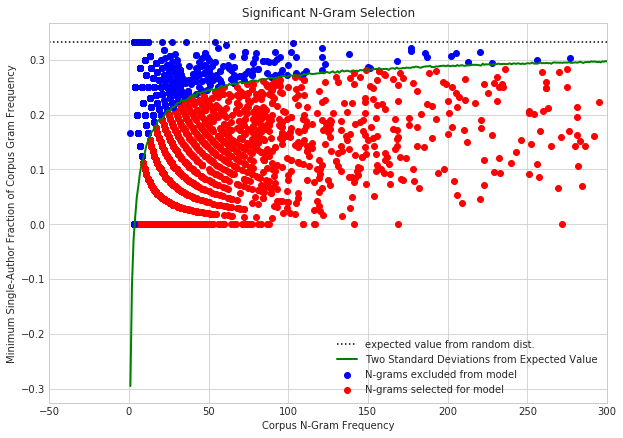

In [153]:
x = list(np.array(ftot[0, :])[0])
y1 = list(fmin[0, :])
y2 = list(fmax[0, :])
plt.figure(figsize=(10, 7))

plt.title('Significant N-Gram Selection')
for i in range(0, len(x)):
    gram = str(voc.loc[i][0][0])
    style = 'o'
    color = 'blue'
    if gram in best_grams:
        style = 'x'
        color = 'red'
    plt.scatter(x=x[i], y=y1[i], color=color);
plt.axhline(y=1/3, linestyle='dotted', color='black', label='expected value from random dist.')
lk = exp_devs.iloc[:1240]
plt.plot(
    exp_devs['global_frequency'], 
    (1/3 - ((4/3)*exp_devs['expected_standard_deviation'])),
    color='green',
    linewidth=3,
    label = 'Two Standard Deviations from Expected Value'
)
plt.scatter(x=1, y=1/6, color='blue', label='N-grams excluded from model');
plt.scatter(x=30, y=1/6, color='red', label='N-grams selected for model');
plt.ylabel('Minimum Single-Author Fraction of Corpus Gram Frequency');
plt.xlabel('Corpus N-Gram Frequency');
plt.xlim((-50, 500))
plt.ylim((-.5, .35))
plt.legend();
plt.show();

In [140]:
frac = len(best_grams)/len(voc)
print('-'*40)
print('\n{}% of N-grams included in model.\n'.format(str(frac*100)[:5]))
print('-'*40)

----------------------------------------

57.29% of N-grams included in model.

----------------------------------------


In [141]:
best_vec = CountVectorizer(vocabulary=best_grams, ngram_range=(1,5))
best_vec.fit(list())
X2 = best_vec.transform(data.recombined)

In [143]:
nb1 = BernoulliNB(alpha=1)
t1 = time()
print('Testing NB Model...')
nb2_scores = pd.Series(cross_val_score(nb1, X2, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', nb2_scores.mean(), ' +/- ', nb2_scores.std())
print('Cross validation completed in: ', time() - t1, ' seconds')
nb2_acc_scores = pd.Series(cross_val_score(nb1, X2, Y, cv=5))
nb2_time = time() - t1
print('5-fold mean accuracy: ', nb2_acc_scores.mean(), ' +/- ', nb2_acc_scores.std())
print('Cross validation completed in: ', nb2_time, ' seconds')

Testing NB Model...
5-fold mean log loss:  0.454842942932  +/-  0.0118676840099
Cross validation completed in:  0.4973933696746826  seconds
5-fold mean accuracy:  0.82828535908  +/-  0.00407474857936
Cross validation completed in:  0.9241681098937988  seconds


In [144]:
rf2 = RandomForestClassifier()
t1 = time()
print('Testing RF Model...')
rf2_scores = pd.Series(cross_val_score(rf2, X2, Y, scoring=logl_score, cv=5))
print('5-fold mean log loss: ', rf2_scores.mean(), ' +/- ', rf2_scores.std())
rf2_acc_scores = pd.Series(cross_val_score(rf1, X2, Y, cv=5))
rf2_time = time() - t1
print('5-fold mean accuracy: ', rf2_acc_scores.mean(), ' +/- ', rf2_acc_scores.std())
print('Cross validation completed in: ', rf2_time, ' seconds')

Testing RF Model...
5-fold mean log loss:  1.59543926474  +/-  0.062877522592
5-fold mean accuracy:  0.656775673564  +/-  0.00996365035829
Cross validation completed in:  39.03123497962952  seconds


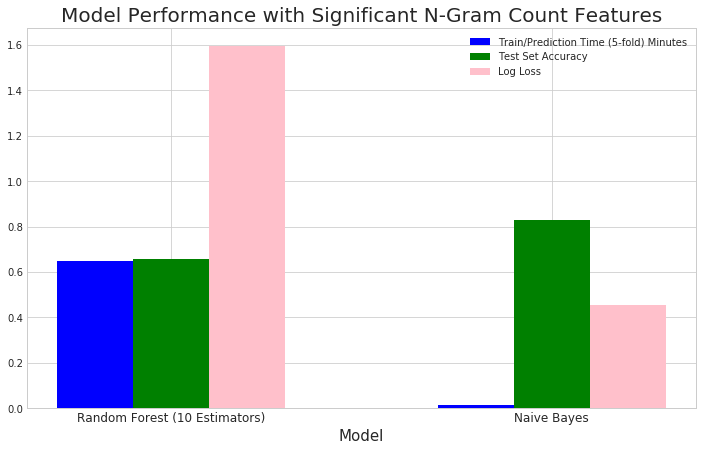

In [148]:
bar_width = .2
x = np.arange(2)
times = [rf2_time/60, nb2_time/60]
accs = [rf2_acc_scores.mean(), nb2_acc_scores.mean()]
losses = [rf2_scores.mean(), nb2_scores.mean()]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance with Significant N-Gram Count Features', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) Minutes');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, ['Random Forest (10 Estimators)', 'Naive Bayes'], fontsize=12);
plt.show();

<H1>Model 3: Probabilities from Parts of Speech with Markov Model</H1>

In [192]:
stratCV = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=.10, random_state=1)
train_inds, test_inds = next(stratCV.split(data['text'], data['author']))

train_pos = data.loc[train_inds, 'pos_list'].reset_index(drop=True)
test_pos = data.loc[test_inds, 'pos_list'].reset_index(drop=True)
train_label = data.loc[train_inds, 'author'].reset_index(drop=True)
test_label = data.loc[test_inds, 'author'].reset_index(drop=True)

t1 = time()
pos_dict = dict()
for key in ['tot', 'EAP', 'HPL', 'MWS']:
    pos_dict[key] = []
    
for sentence, author in zip(train_pos, train_label):
    pos_dict['tot'] += sentence
    pos_dict[author] += sentence
    
pos_desc = {
    'CC': 'coord conjunction',
    'CD': 'cardinal digit',
    'DT': 'determiner',
    'EX': 'existential "there"',
    'FW': 'foreign word',
    'IN': 'prep/sub conjunction',
    'JJ': 'adjective',
    'JJR': 'comp. adjective',
    'JJS': 'superl. adjective',
    'LS': 'list marker',
    'MD': 'modal',
    'NN': 'noun, sing.',
    'NNS': 'noun, pl.',
    'NNP': 'proper noun, sing.',
    'NNPS': 'proper noun, pl.',
    'PDT': 'predeterminer',
    'POS': 'possessive "s"',
    'PRP': '1st pronoun',
    'PRP$': 'poss pronoun',
    'RB': 'adverb',
    'RBR': 'comp. adverb',
    'RBS': 'superl. adverb',
    'RP': 'particle',
    'TO': 'inf. "to"',
    'UH': 'interjection',
    'VB': 'inf. verb',
    'VBD': 'verb, past',
    'VBG': 'verb, gerund',
    'VBN': 'verb, past part',
    'VBP': 'verb, sing. pres',
    'VBZ': 'verb, 3rd prs sing pres',
    'WDT': 'wh-determiner',
    'WP': 'wh-pronoun',
    'WP$': 'possessive wh-pronoun',
    'WRB': 'wh-abverb',
    ',': 'comma',
    ':': 'colon',
    ';': 'semitcolon',
    '.': 'period',
    '"': 'quotation',
    "'": 'apostrophe',
    'start': '',
    'end': ''
}

for pos in pos_dict['tot']:
    if pos not in pos_desc:
        pos_desc[pos] = pos

In [193]:
pos_encoder = preprocessing.LabelEncoder()
pos_encoder.fit(pos_dict['tot'] + ['start'])

pos_counts_EAP = np.histogram(pos_encoder.transform(pos_dict['EAP']), range(len(pos_encoder.classes_)+1), density=True)[0]
pos_counts_HPL = np.histogram(pos_encoder.transform(pos_dict['HPL']), range(len(pos_encoder.classes_)+1), density=True)[0]
pos_counts_MWS = np.histogram(pos_encoder.transform(pos_dict['MWS']), range(len(pos_encoder.classes_)+1), density=True)[0]

sorted_pos = np.flipud(np.argsort(pos_counts_EAP + pos_counts_HPL + pos_counts_MWS))

authors = ['EAP', 'HPL', 'MWS']
logPs = []
predictions = []
for i, (sentence, author) in enumerate(zip(test_pos, test_label)):
    poss = sentence
    logP_EAP = sum([np.log(pos_counts_EAP[pos_encoder.classes_ == pos]) for pos in poss])
    logP_HPL = sum([np.log(pos_counts_HPL[pos_encoder.classes_ == pos]) for pos in poss])
    logP_MWS = sum([np.log(pos_counts_MWS[pos_encoder.classes_ == pos]) for pos in poss])
    
    logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))
    predictions.append(authors[np.argmax(logPs[-1])])
    
acc = (test_label == predictions).mean()
marko0_time = time() - t1

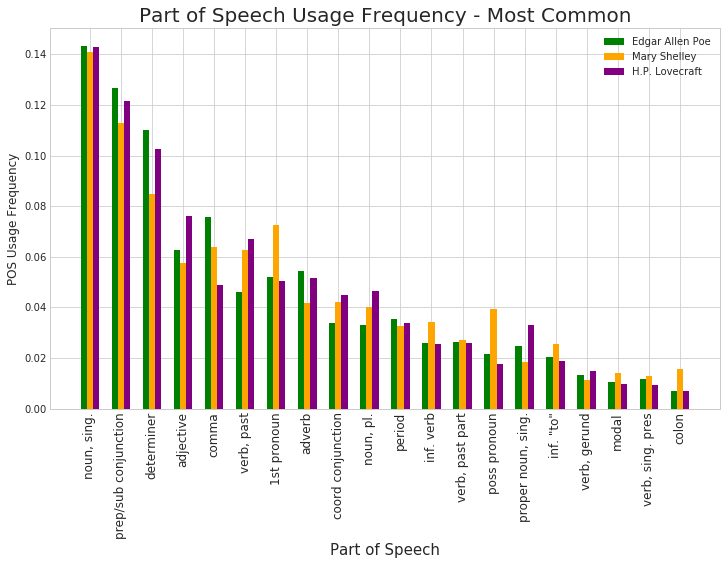

In [194]:
bar_width = .2
cutoff = int(len(pos_counts_EAP)/2)
sorted_pos1 = sorted_pos[:cutoff]
x = np.arange(cutoff)

plt.figure(figsize=(12, 7)); 
plt.title('Part of Speech Usage Frequency - Most Common', fontsize=20);
plt.bar(x-bar_width, pos_counts_EAP[sorted_pos1], bar_width, color='green', label='Edgar Allen Poe');
plt.bar(x, pos_counts_MWS[sorted_pos1], bar_width, color='orange', label='Mary Shelley');
plt.bar(x+bar_width, pos_counts_HPL[sorted_pos1], bar_width, color='purple', label='H.P. Lovecraft');
plt.legend();
plt.ylabel('POS Usage Frequency', fontsize=12);
plt.xlabel('Part of Speech', fontsize=15);
plt.xticks(x, [pos_desc[j] for j in['{}'.format(pos_encoder.classes_[i]) for i in sorted_pos1]], fontsize=12, rotation=90);
plt.show();

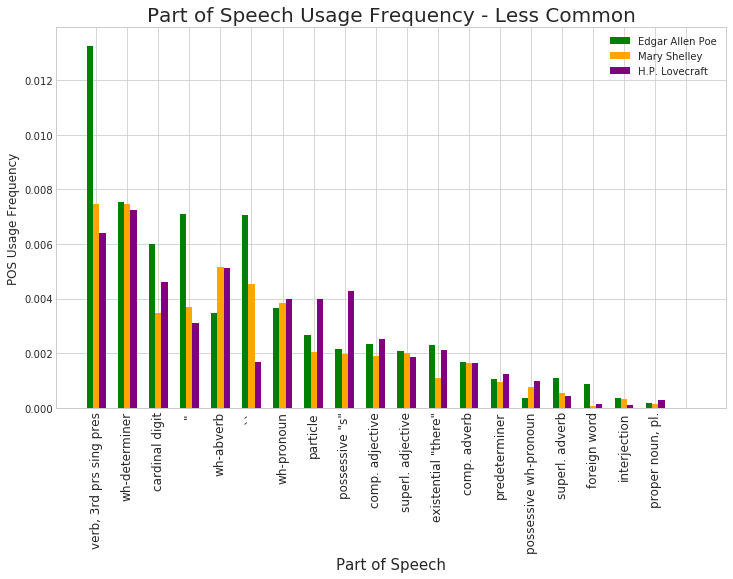

In [195]:
bar_width = .2
cutoff = int(len(pos_counts_EAP)/2)
sorted_pos2 = sorted_pos[cutoff:]
x = np.arange(cutoff)

plt.figure(figsize=(12, 7)); 
plt.title('Part of Speech Usage Frequency - Less Common', fontsize=20);
plt.bar(x-bar_width, pos_counts_EAP[sorted_pos2], bar_width, color='g', label='Edgar Allen Poe');
plt.bar(x, pos_counts_MWS[sorted_pos2], bar_width, color='orange', label='Mary Shelley');
plt.bar(x+bar_width, pos_counts_HPL[sorted_pos2], bar_width, color='purple', label='H.P. Lovecraft');
plt.legend();
plt.ylabel('POS Usage Frequency', fontsize=12);
plt.xlabel('Part of Speech', fontsize=15);
plt.xticks(x, [pos_desc[j] for j in ['{}'.format(pos_encoder.classes_[i]) for i in sorted_pos2]], fontsize=12, rotation=90);
plt.show();

In [196]:
print('prediction accuracy on test set: ', str(100*acc)[:4], '%')
Ps = [e**(x) for x in logPs]
Ps = [(1/sum(x)) * x for x in Ps]
probs = np.array(Ps).reshape(1958, 3)
for i, thing in enumerate(probs):
    if np.isnan(thing).any():
        probs[i] = 0
        
loss = log_loss(test_label, probs)
print('log loss on test set: ', str(loss)[:4])

prediction accuracy on test set:  54.8 %
log loss on test set:  0.98


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


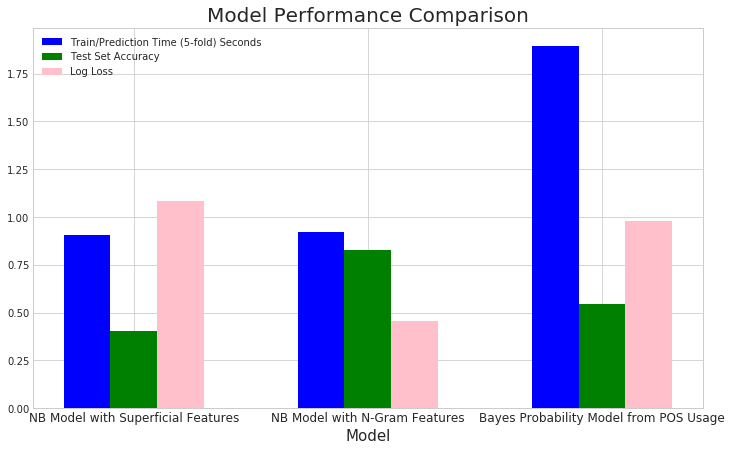

In [201]:
bar_width = .2
x = np.arange(3)
times = [nb1_time, nb2_time, marko0_time]
accs = [nb1_acc_scores.mean(), nb2_acc_scores.mean(), acc]
losses = [nb1_scores.mean(), nb2_scores.mean(), loss]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance Comparison', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) Seconds');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, ['NB Model with Superficial Features', 'NB Model with N-Gram Features', 'Bayes Probability Model from POS Usage'], fontsize=12);
plt.show();

<H2>1st Order Markov Model</H2><br>
Remembers one previous POS state.

In [208]:
order = 1

t1 = time()
history = []
next_pos = []
author = []
for i, (sentence, auth) in enumerate(zip(train_pos, train_label)):
    sentence = ['start'] + sentence
    history += sentence[:-1]
    next_pos += sentence[1:]
    author += [auth]*(len(sentence)-1)
    
corp_df = pd.DataFrame(columns=['author', 'history', 'next_pos'])
corp_df['author'] = author
corp_df['history'] = history
corp_df['next_pos'] = next_pos

pos_cond_prob = {}
for auth in authors:
    pos_cond_prob[auth] = np.zeros( (1+order)*[pos_encoder.classes_.shape[0]])

pos_cond_counts = {}
for auth in authors:
    pos_cond_counts[auth] = np.zeros( (1+order)*[pos_encoder.classes_.shape[0]])    

corp_df_byauth = corp_df.groupby('author', axis=0)
for auth in authors:
    author_corp_df = corp_df_byauth.get_group(auth).loc[:,['history', 'next_pos']].reset_index(drop=True)
    author_corp_byhist = author_corp_df.groupby('history', axis=0)
    for history in author_corp_df.history.unique():
        author_history_df = author_corp_byhist.get_group(history).reset_index(drop=True).loc[:, ['next_pos']].reset_index(drop=True)
        enc_history = pos_encoder.transform([history])[0]
        enc_next_pos_counts = np.histogram(pos_encoder.transform(author_history_df), range(len(pos_encoder.classes_)+1), density=False)[0]
        enc_next_pos_prob = np.histogram(pos_encoder.transform(author_history_df), range(len(pos_encoder.classes_)+1), density=True)[0]
        
        pos_cond_prob[auth][enc_history,:] = enc_next_pos_prob
        pos_cond_counts[auth][enc_history,:] = enc_next_pos_counts
    
pos_cond_prob['all']  = (pos_cond_prob['EAP']  + pos_cond_prob['HPL']  + pos_cond_prob['MWS'] )/3.0
pos_cond_counts['all'] =  pos_cond_counts['EAP'] + pos_cond_counts['HPL'] + pos_cond_counts['MWS']

pos_desc['start'] = 'start of sentence'

auth_prior_frac = .0001
all_prior_frac = .0001

prior = np.array([1 - (auth_prior_frac+all_prior_frac), auth_prior_frac, all_prior_frac])
all_prior_value = 1/len(pos_encoder.classes_)

logPs = []
cond_p_o1 = {}
for auth in authors:
    cond_p_o1[auth] = prior[0]*pos_cond_prob[auth]
    cond_p_o1[auth] += prior[1]*pos_cond_prob['all']
    cond_p_o1[auth] += prior[2]*all_prior_frac
    
predictions = []
for i, (sentence, authoer) in enumerate(zip(test_pos, test_label)):
    pos_sequences = [sentence[i: i + order + 1] for i in range(len(sentence)-order)]
    
    history = [seq[:-1] for seq in pos_sequences]
    next_pos = [seq[-1] for seq in pos_sequences]
    
    logP_EAP = 0
    logP_HPL = 0
    logP_MWS = 0
    
    for hist_pos, nxt in zip(history, next_pos):
        enc_hist_pos = pos_encoder.transform([hist_pos])[0]
        enc_next_pos = pos_encoder.transform([nxt])[0]
        
        logP_EAP += np.log(cond_p_o1['EAP'][enc_hist_pos, enc_next_pos])
        logP_HPL += np.log(cond_p_o1['HPL'][enc_hist_pos, enc_next_pos])
        logP_MWS += np.log(cond_p_o1['MWS'][enc_hist_pos, enc_next_pos])
        
        
    predictions.append(authors[np.argmax([logP_EAP, logP_HPL, logP_MWS])])
    logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))

marko1_time = time() - t1

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


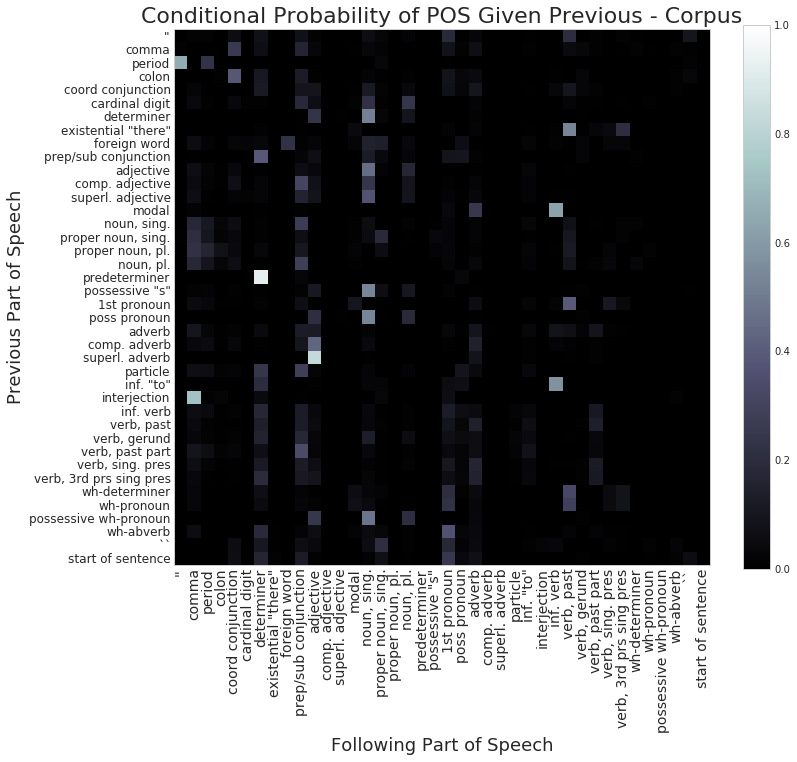

In [209]:
cond_prob = pos_cond_prob['all']

plt.figure(figsize=(12,10))
plt.imshow(cond_prob, cmap='bone');  
plt.colorbar(); 
plt.clim(0,1);
plt.grid('off'); plt.title('Conditional Probability of POS Given Previous - Corpus', fontsize=22);
plt.xlabel('Following Part of Speech', fontsize=18); plt.ylabel('Previous Part of Speech', fontsize=18);
plt.xticks(
    range(cond_prob.shape[0]),
    [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]], 
    rotation=90,
    fontsize=14
);
plt.yticks(
    range(cond_prob.shape[0]),
    [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]],
    fontsize=12
);
plt.show();

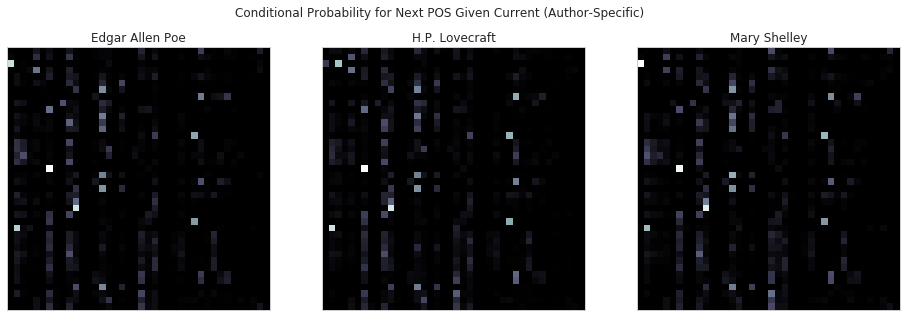

In [210]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Conditional Probability for Next POS Given Current (Author-Specific)')
ax1 = ax[0]
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Edgar Allen Poe')
ax1.imshow(pos_cond_prob['EAP'], cmap='bone');
ax2 = ax[1]
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('H.P. Lovecraft')
ax2.imshow(pos_cond_prob['HPL'], cmap='bone');
ax3 = ax[2]
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Mary Shelley')
ax3.imshow(pos_cond_prob['MWS'], cmap='bone');
plt.show();

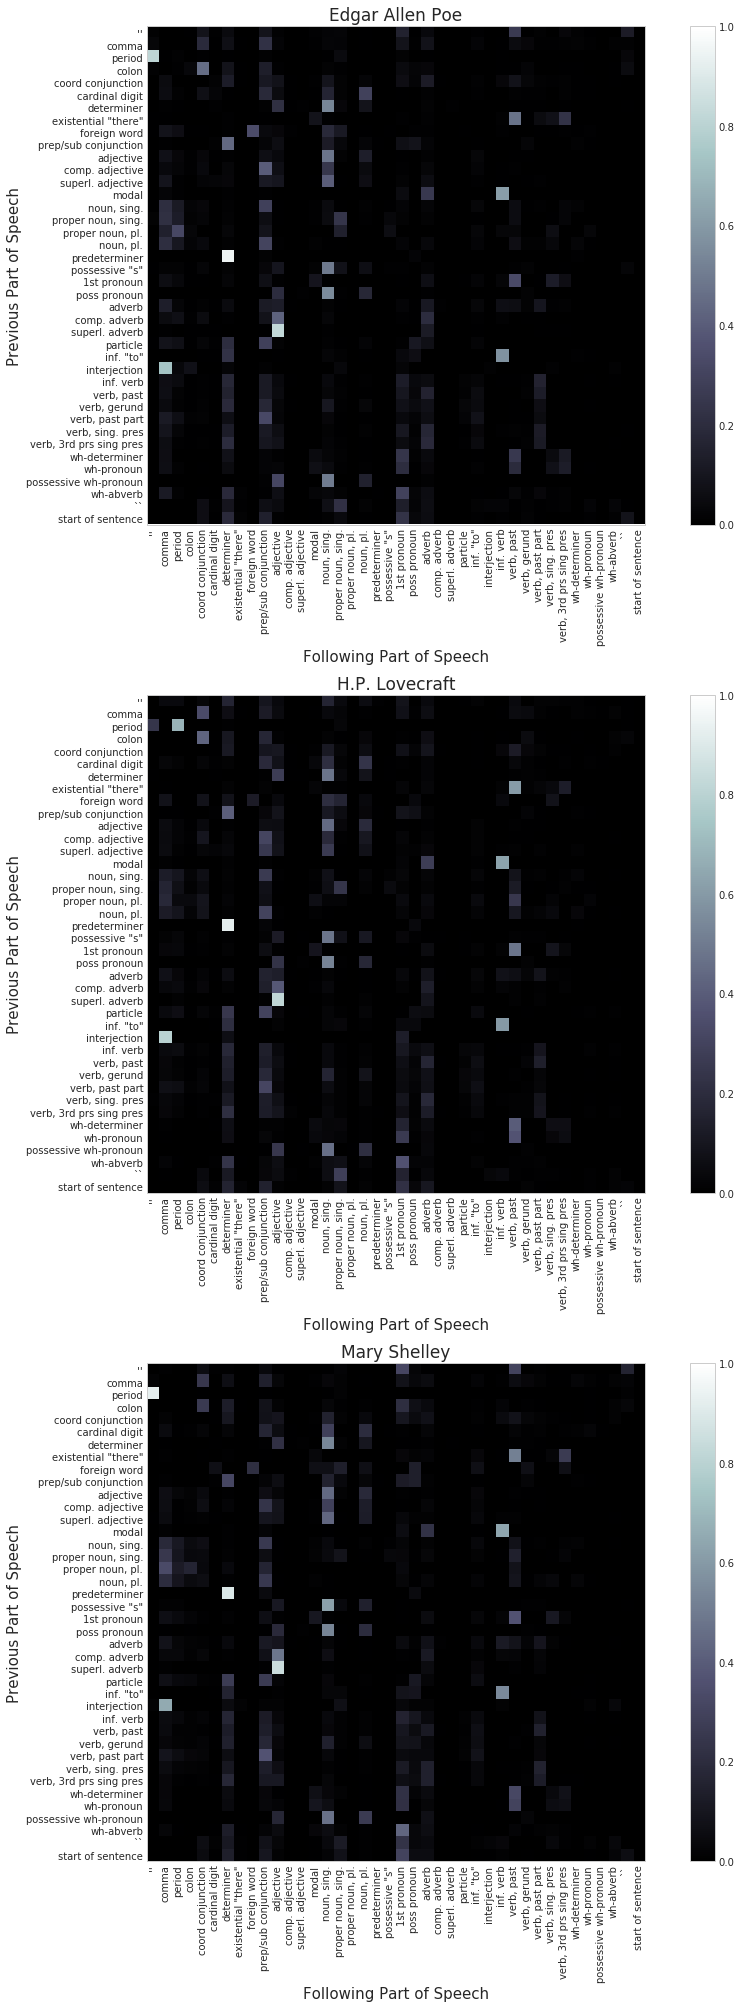

In [211]:
names = {}
names['EAP'] = 'Edgar Allen Poe'
names['HPL'] = 'H.P. Lovecraft'
names['MWS'] = 'Mary Shelley'

plt.figure(figsize=(13,28))
for i, author in enumerate(['EAP','HPL','MWS']):
    cond_prob = pos_cond_prob[author]
    plt.subplot(3,1,i+1); plt.imshow(cond_prob, cmap='bone'); 
    plt.grid('off'); plt.colorbar(); plt.clim(0,1);
    plt.title('{}'.format(names[author]), fontsize=17);
    plt.xlabel('Following Part of Speech', fontsize=15); plt.ylabel('Previous Part of Speech', fontsize=15);
    plt.xticks(
        range(cond_prob.shape[0]),
        [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]],
        rotation = 90
    );
    plt.yticks(
        range(cond_prob.shape[0]),
        [pos_desc[j] for j in['{}'.format(i) for i in pos_encoder.classes_]]
    );
plt.tight_layout();
plt.show();

In [215]:
acco1 = (test_label == predictions).mean()
print('prediction accuracy on test set: ', str(100*(acco1))[:4], '%')
logPs = np.array(logPs)
Ps = [e**(x) for x in logPs]
Ps = [(1/sum(x)) * x for x in Ps]
probs = np.array(Ps).reshape(1958, 3)
for i, thing in enumerate(probs):
    if np.isnan(thing).any():
        probs[i] = 0
      
losso1 = log_loss(test_label, probs)
print('log loss on test set: ', str(losso1)[:5])

prediction accuracy on test set:  62.8 %
log loss on test set:  0.932


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


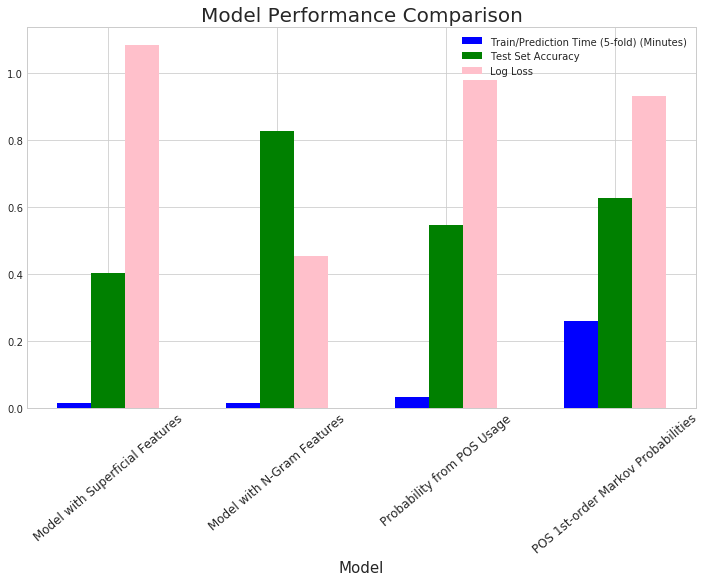

In [218]:
bar_width = .2
x = np.arange(4)
times = [nb1_time/60, nb2_time/60, marko0_time/60, marko1_time/60]
accs = [nb1_acc_scores.mean(), nb2_acc_scores.mean(), acc, acco1]
losses = [nb1_scores.mean(), nb2_scores.mean(), loss, losso1]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance Comparison', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) (Minutes)');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, ['Model with Superficial Features', 'Model with N-Gram Features', 'Probability from POS Usage', 'POS 1st-order Markov Probabilities'], rotation=40, fontsize=12);
plt.show();

<H2>Higher Order Markov Model</H2><br>
Models that remember 2+ previous states.

In [252]:
def get_corpus_df(data, train_inds, order=2):
    """Takes dataframe and integer argument for order of Markov model. Returns a dataframe with
    POS states of length (order), author names, and next state.
    """
    hist_list = []
    nxt_pos_list = []
    author_list = []
    for i, (sentence, author) in enumerate(zip(data.loc[train_inds].pos_list, data.loc[train_inds].author)):
        pos_seqs = [sentence[i:i+order+1] for i in range(len(sentence)-order)]
        history = [seq[:-1] for seq in pos_seqs]
        next_pos = [seq[-1] for seq in pos_seqs]
        
        hist_list += history
        nxt_pos_list += next_pos
        author_list += [author]*len(history)
        
    result = pd.DataFrame(columns=['author', 'history', 'next_pos'])
    result['author'] = author_list
    result['history'] = hist_list
    result.history = result.history.apply(lambda x: tuple(x))
    result['next_pos'] = nxt_pos_list
    return result

def get_models(corpus_df, encoder, order=2):
    """Takes the corpus df output from get_corpus_df, an encoder, and
    order number and returns two dictionaries with three authors and 'all'
    keys corresponding to (1) conditional probability and (2) count matrices for model.
    """
    resultp = {}
    for author in ['EAP','HPL','MWS']:
        resultp[author] = np.zeros( (1+order)*[encoder.classes_.shape[0]] )
    resultc = {}
    for author in ['EAP','HPL','MWS']:
        resultc[author] = np.zeros( (1+order)*[encoder.classes_.shape[0]] )

    corpus_by_author = corpus_df.groupby(by='author',axis=0)
    for author in corpus_df['author'].unique():
        author_corpus_df = corpus_by_author.get_group(author).loc[:,['history','next_pos']].reset_index(drop=True)
        author_corpus_by_history = author_corpus_df.groupby(by='history',axis=0)
        for history in author_corpus_df['history'].unique():
            author_hist_df = author_corpus_by_history.get_group(history).reset_index(drop=True).loc[:,'next_pos'].reset_index(drop=True)
            #return author_corpus_df
            enc_hist = encoder.transform([pos for pos in history])
            enc_next_pos_counts = np.histogram(encoder.transform(author_hist_df),range(len(encoder.classes_)+1),density=False)[0]
            enc_next_pos_probs   = np.histogram(encoder.transform(author_hist_df),range(len(encoder.classes_)+1),density=True)[0]

            resultp[author][enc_hist[0], enc_hist[1],:] = enc_next_pos_probs
            resultc[author][enc_hist[0], enc_hist[1],:] = enc_next_pos_counts


    resultp['all']  = (resultp['EAP']  + resultp['HPL']  + resultp['MWS'] )/3.0
    resultc['all'] =  resultc['EAP'] + resultc['HPL'] + resultc['MWS']

    return resultp, resultc

def predict_probs2(data, test_inds, prob_mat, encoder, uniform_prior=.1, auth_prior=.1):
    """Takes dataframe, test indices (test_inds), prob & count matrices from get_models, encoder, and 
    optional keyword arguments for priors and order (must match order of input matrices)
    """
    order=2
    logPs = []
    prior = np.array([1.0-uniform_prior-auth_prior, auth_prior, uniform_prior])
    uniform_prior_value = 1.0/len(encoder.classes_)

    condP = {}
    authors_list = ['EAP','HPL','MWS']
    for author in authors_list:
        condP[author]  = prior[0]*prob_mat[author]
        condP[author] += prior[1]*prob_mat['all']
        condP[author] += prior[2]*uniform_prior

    predictions = []
    for i, (sentence, author) in enumerate(zip(data.loc[test_inds].pos_list, data.loc[test_inds].author)):
        pos_seqs = [sentence[i:i+order+1] for i in range(len(sentence)-order)]

        history  = [seq[:-1] for seq in pos_seqs]
        next_pos = [seq[-1] for seq in pos_seqs]

        logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
        for hist_pos, next_pos in zip(history, next_pos):
            enc_hist_pos = encoder.transform([pos for pos in hist_pos])
            enc_next_pos  = encoder.transform([next_pos])[0]

            logP_EAP += np.log(condP['EAP'][enc_hist_pos[0],enc_hist_pos[1],enc_next_pos])
            logP_HPL += np.log(condP['HPL'][enc_hist_pos[0],enc_hist_pos[1],enc_next_pos])
            logP_MWS += np.log(condP['MWS'][enc_hist_pos[0],enc_hist_pos[1],enc_next_pos])

        predictions.append(authors_list[np.argmax([logP_EAP,logP_HPL,logP_MWS])])
        logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))
    acc = (data.loc[test_inds].author == predictions).mean()
    logPs = np.array(logPs)
    Ps = [e**(x) for x in logPs]
    Ps = [(1/sum(x)) * x for x in Ps]
    shp = len(test_inds)
    probs = np.array(Ps).reshape(shp, 3)
    for i, thing in enumerate(probs):
        if np.isnan(thing).any():
            probs[i] = 0
    
    return probs, acc



In [232]:
t1 = time()
corp_df = get_corpus_df(data, train_inds)
pos_cond_prob, pos_cond_counts = get_models(corp_df, pos_encoder, order=2)
probs, acco2 = predict_probs2(data, test_inds, pos_cond_prob, pos_encoder, uniform_prior=.1, auth_prior=.1)
marko2_time = time() - t1
losso2 = log_loss(test_label, probs)
print('accuracy on test set: ', str(acc*100)[:5], '%')
print('log loss on test set: ', str(log_loss(test_label, probs))[:5])

accuracy on test set:  54.80 %
log loss on test set:  0.876


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in double_scalars
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in multiply


In [233]:
def predict_probs3(data, test_inds, prob_mat, encoder, uniform_prior=.1, auth_prior=.1):
    """Takes dataframe, test indices (test_inds), prob & count matrices from get_models, encoder, and 
    optional keyword arguments for priors and order (must match order of input matrices)
    """
    order=3
    logPs = []
    prior = np.array([1.0-uniform_prior-auth_prior, auth_prior, uniform_prior])
    uniform_prior_value = 1.0/len(encoder.classes_)

    condP = {}
    authors_list = ['EAP','HPL','MWS']
    for author in authors_list:
        condP[author]  = prior[0]*prob_mat[author]
        condP[author] += prior[1]*prob_mat['all']
        condP[author] += prior[2]*uniform_prior

    predictions = []
    for i, (sentence, author) in enumerate(zip(data.loc[test_inds].pos_list, data.loc[test_inds].author)):
        pos_seqs = [sentence[i:i+order+1] for i in range(len(sentence)-order)]

        history  = [seq[:-1] for seq in pos_seqs]
        next_pos = [seq[-1] for seq in pos_seqs]

        logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
        for hist_pos, next_pos in zip(history, next_pos):
            enc_hist_pos = encoder.transform([pos for pos in hist_pos])
            enc_next_pos  = encoder.transform([next_pos])[0]

            logP_EAP += np.log(condP['EAP'][enc_hist_pos[0],enc_hist_pos[1],enc_hist_pos[2],enc_next_pos])
            logP_HPL += np.log(condP['HPL'][enc_hist_pos[0],enc_hist_pos[1],enc_hist_pos[2],enc_next_pos])
            logP_MWS += np.log(condP['MWS'][enc_hist_pos[0],enc_hist_pos[1],enc_hist_pos[2],enc_next_pos])

        predictions.append(authors_list[np.argmax([logP_EAP,logP_HPL,logP_MWS])])
        logPs.append(np.array([logP_EAP, logP_HPL, logP_MWS]))
    acc = (data.loc[test_inds].author == predictions).mean()
    print(52*'-')
    print('==> Tet Set Classification Accuracy = %.1f%s' %(100*acc,'%'))
    print(52*'-')
    logPs = np.array(logPs)
    Ps = [e**(x) for x in logPs]
    Ps = [(1/sum(x)) * x for x in Ps]
    probs = np.array(Ps).reshape(1958, 3)
    for i, thing in enumerate(probs):
        if np.isnan(thing).any():
            probs[i] = 0
    
    return probs, acc

In [234]:
t1 = time()
corp_df = get_corpus_df(data, train_inds, order=3)
pos_cond_prob, pos_cond_counts = get_models(corp_df, pos_encoder, order=3)
probs, acco3 = predict_probs3(data, test_inds, pos_cond_prob, pos_encoder, uniform_prior=10, auth_prior=10)
marko3_time = time() - t1
losso3 = log_loss(test_label, probs)
print('log loss on test set: ', str(log_loss(test_label, probs))[:5])

----------------------------------------------------
==> Tet Set Classification Accuracy = 30.4%
----------------------------------------------------
log loss on test set:  1.132


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in power
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in multiply


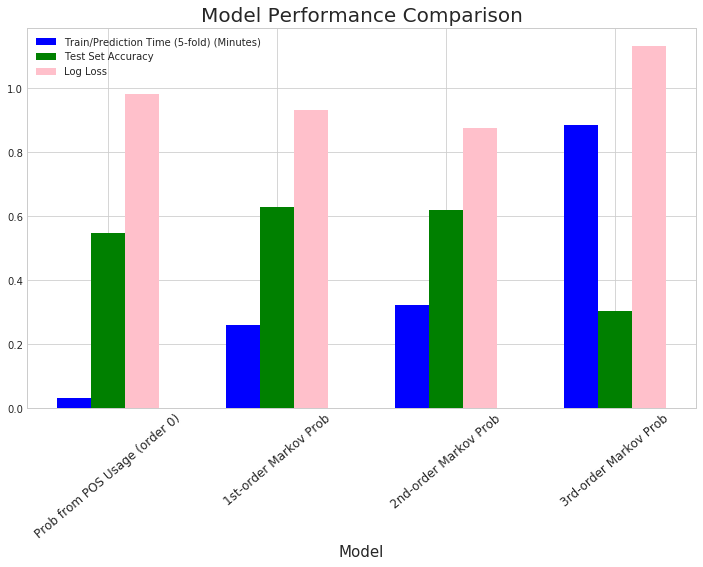

In [235]:
bar_width = .2
x = np.arange(4)
times = [marko0_time/60, marko1_time/60, marko2_time/60, marko3_time/60]
accs = [acc, acco1, acco2, acco3]
losses = [loss, losso1, losso2, losso3]
sns.set_style('whitegrid')

plt.figure(figsize=(12, 7)); 
plt.title('Model Performance Comparison', fontsize=20);
plt.bar(x-bar_width, times, bar_width, color='blue', label='Train/Prediction Time (5-fold) (Minutes)');
plt.bar(x, accs, bar_width, color='green', label='Test Set Accuracy');
plt.bar(x+bar_width, losses, bar_width, color='pink', label='Log Loss');
plt.legend();
plt.xlabel('Model', fontsize=15);
plt.xticks(x, 
           [
               'Prob from POS Usage (order 0)', 
               '1st-order Markov Prob',
               '2nd-order Markov Prob',
               '3rd-order Markov Prob'
           ], 
           rotation=40, 
           fontsize=12
            );
plt.show();

<H1>Ensembling the Models</H1><br>
Combine three best models to improve log-loss.

In [257]:
df = data[['id', 'text', 'author']].copy()

In [258]:
def prepare_data(data):
    """Calls data prep functions and returns appended df,
    list of features used in first model.
    """
    res = data
    res = tokenize_text(res)
    res, fts = build_features(res)
    res = lemmatize_text(res)
    return res, fts

def apply_model_1(df, itrain, itest, fts):
    """takes dataframe, train indices, test indices, and list
    of feature names used in first model. Returns a dataframe
    with probabilities for each author for the test set.
    """
    mod = BernoulliNB()
    mod.fit(df[fts].loc[itrain], df.author.loc[itrain])
    cls = mod.classes_
    probs = mod.predict_proba(df[fts].loc[itest])
    res = pd.DataFrame(data=probs, index=itest, columns=['{}_prob1'.format(clas) for clas in cls])
    return res

def apply_model_2(df, itrain, itest, vec):
    """takes dataframe, train indices, test indices, and word vectorizer
    from second model. Returns a dataframe
    with probabilities for each author for the test set.
    """
    mod = BernoulliNB()
    X_train = vec.transform(df.recombined.loc[itrain])
    X_test = vec.transform(df.recombined.loc[itest])
    mod.fit(X_train, df.author.loc[itrain])
    cls = mod.classes_
    probs = mod.predict_proba(X_test)
    res = pd.DataFrame(data=probs, index=itest, columns=['{}_prob2'.format(clas) for clas in cls])
    return res

def apply_model_3(df, itrain, itest, encoder):
    """takes dataframe, train indices, test indices, and encoder
    from third model. Returns a dataframe with probabilities for 
    each author for the test set.
    """
    corp_df = get_corpus_df(df, train_inds)
    pos_cond_prob, pos_cond_counts = get_models(corp_df, encoder, order=2)
    probs, acco2 = predict_probs2(data, itest, pos_cond_prob, encoder, uniform_prior=.1, auth_prior=.1)
    cls = ['EAP', 'HPL', 'MWS']
    res = pd.DataFrame(data=probs, index=itest, columns=['{}_prob3'.format(clas) for clas in cls])
    return res

In [259]:
fld = StratifiedKFold(n_splits=5, random_state=123)
df, fts = prepare_data(df)
res1, res2, res3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for itrain, itest in fld.split(df['text'], df['author']):
    print('Starting fold...')
    res1 = pd.concat([res1, apply_model_1(df, itrain, itest, fts)], axis=0)
    res2 = pd.concat([res2, apply_model_2(df, itrain, itest, best_vec)], axis=0)
    res3 = pd.concat([res3, apply_model_3(df, itrain, itest, pos_encoder)], axis=0)
    
results = pd.concat([res1, res2, res3], axis=1)
results.head()

Starting fold...
Starting fold...


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in double_scalars
/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in multiply


Starting fold...
Starting fold...
Starting fold...


,EAP_prob1,HPL_prob1,MWS_prob1,EAP_prob2,HPL_prob2,MWS_prob2,EAP_prob3,HPL_prob3,MWS_prob3
0,0.387250,0.302559,0.310191,9.999905e-01,6.982839e-06,2.565292e-06,0.893227,0.001537,0.105236
1,0.479375,0.219045,0.301579,9.411036e-01,4.004304e-02,1.885338e-02,0.419049,0.389205,0.191746
2,0.387250,0.302559,0.310191,9.990680e-01,9.317419e-04,2.666221e-07,0.393380,0.585729,0.020890
3,0.387250,0.302559,0.310191,1.210504e-09,4.746395e-07,9.999995e-01,0.001148,0.728198,0.270654
4,0.387250,0.302559,0.310191,8.841572e-01,1.097254e-01,6.117441e-03,0.654960,0.119880,0.225160


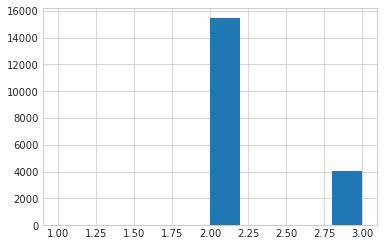

In [260]:
results['most_confident'] = pd.Series([x[-1] for x in results.idxmax(axis=1)]).astype(int)
results.most_confident.hist();
plt.show();

In [261]:
ensemble_predictions = pd.DataFrame(index=df.index, columns=['EAP', 'MWS', 'HPL'])
ensemble_predictions[['EAP', 'MWS', 'HPL']] = 0
for i in df.index:
    winner = int(results.loc[i].most_confident)
    ensemble_predictions.set_value(i, 'EAP', results['EAP_prob{}'.format(winner)].loc[i])
    ensemble_predictions.set_value(i, 'MWS', results['MWS_prob{}'.format(winner)].loc[i])
    ensemble_predictions.set_value(i, 'HPL', results['HPL_prob{}'.format(winner)].loc[i])
    

In [262]:
Y_true = df.author
Y_pred = ensemble_predictions[['EAP', 'HPL', 'MWS']]
log_loss(Y_true, Y_pred)

0.3826772283333475

In [263]:
Y_true = df.author
Y_pred = res2[['EAP_prob2', 'HPL_prob2', 'MWS_prob2']]
log_loss(Y_true, Y_pred)

0.54524341025423839

In [264]:
ensemble_predictions['pred_auth'] = ensemble_predictions[['EAP', 'HPL', 'MWS']].idxmax(axis=1)
ensemble_predictions['true_auth'] = df.author
ensemble_predictions['winning_model'] = results.most_confident
ensemble_predictions['correct'] = np.where((ensemble_predictions.pred_auth==ensemble_predictions.true_auth), 1, 0)

In [265]:
ens_acc = ensemble_predictions.correct.sum()/len(ensemble_predictions)

0.86940088870728838